In [406]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [407]:
from sklearn.datasets import load_diabetes

In [408]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [409]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
X_train.shape

(331, 10)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [410]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [411]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [412]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [413]:
import random
def subsample(len_sample, percent=0.5):
    indexes = np.array(list(range(len_sample)))
    random.shuffle(indexes)
    return indexes[:round(len_sample * percent)]

In [414]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, percent=1):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []

   
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
         #выбираем произвольно percent процентов выборки

        subsample_indexes = subsample(X_train.shape[0], percent)
        X_train_subset = X_train[subsample_indexes, :]
        y_train_subset = y_train[subsample_indexes]
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список

        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_subset, y_train_subset)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_subset, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_subset, bias(y_train_subset, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [415]:
# Число деревьев в ансамбле
n_trees = 50

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, percent=0.5)

In [416]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [417]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1407.5374975240832
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3381.1198530916927


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [418]:
import matplotlib.pyplot as plt

In [419]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

In [420]:
def get_errors_plot(n_trees, train_err, train_err2, train_err3, train_err4):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='1')
    plt.plot(list(range(n_trees)), train_err2, label='0.5')
    plt.plot(list(range(n_trees)), train_err3, label='0.05')
    plt.plot(list(range(n_trees)), train_err4, label='0.005')
    plt.legend(loc='upper right')
    plt.show()

In [421]:
n_trees = 100
coefs = [1] * n_trees

In [422]:
%%time
trees1, train_errors1, test_errors1 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, percent=1)

Wall time: 3min 56s


In [423]:
%%time
trees2, train_errors2, test_errors2 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, percent=0.5)

Wall time: 3min 14s


In [424]:
%%time
trees3, train_errors3, test_errors3 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, percent=0.05)

Wall time: 2min 23s


In [425]:
%%time
trees4, train_errors4, test_errors4 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, percent=0.005)

Wall time: 2min 17s


Размер ошибки на тестовой выборке в зависимости от количества деревьев в ансамбле. Каждый график соответствует размеру используемой выборки при обучении деревьев. (1 - вся выборка, 0.5 - половина итд)

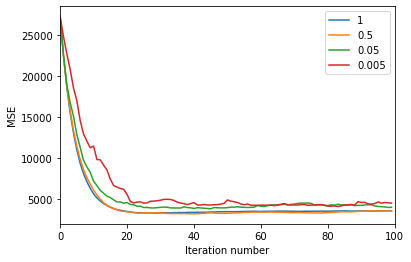

In [427]:
get_errors_plot(n_trees, test_errors1, test_errors2, test_errors3, test_errors4)

Вроде все сделал верно, но результаты немного странные. при выборке 0.005 , за 100 итераций мы используем максимум 50% общей выборки, и это дает нам даже какойто результат за 100 итераций. В таком исполнении они работают не сильно быстрее, но быстрее. Но может я сделал что-то неверно.